In [29]:
# 라이브러리 임포트 및 디렉토리 생성
import os
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# 모델과 관련 객체들을 저장할 디렉토리 생성
model_dir = 'models/rf_db'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [30]:
# 데이터 로드 및 전처리
# 데이터 파일 경로 
data = pd.read_csv("../data/pm25_pm10_merged_wind.csv")

# 날짜 컬럼을 datetime 형식으로 변환 및 계절 정보 생성
def get_season(month):
    if month in [3, 4, 5]:
        return "봄"
    elif month in [6, 7, 8]:
        return "여름"
    elif month in [9, 10, 11]:
        return "가을"
    else:
        return "겨울"

data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Season'] = data['Month'].apply(get_season)

# 2018년 이후 데이터만 사용
data = data[data['Date'].dt.year >= 2018]

# PM2.5 및 PM10 값이 0보다 큰 데이터만 선택
data = data[(data['PM2.5 (µg/m³)'] > 0) & (data['PM10 (µg/m³)'] > 0)]

# 풍속과 풍향을 이용해 Wind_X, Wind_Y 생성
data['Wind_X'] = data['Wind Speed (m/s)'] * np.cos(np.radians(data['Wind Direction (degrees)']))
data['Wind_Y'] = data['Wind Speed (m/s)'] * np.sin(np.radians(data['Wind Direction (degrees)']))

In [31]:
# 중국 및 주변국 데이터 생성 (그룹화,피벗,병합)
# 중국 도시와 주변국 도시 (영문 표기)
china_cities = ['Beijing', 'Shanghai', 'Guangzhou', 'Chongqing', 'Wuhan', 
                'Nanjing', 'Hangzhou', 'Chengdu']
nearby_cities = ['Seoul', 'Tokyo', 'Delhi', 'Bangkok', 'Busan', 'Daegu', 'Osaka', 
                 'Sapporo', 'Fukuoka', 'Kyoto', 'Almaty', 'Bishkek', 'Dushanbe', 
                 'Kathmandu', 'Yangon', 'Guwahati', 'Ulaanbaatar', 'Irkutsk']

# 중국 데이터: 날짜별, 계절별 평균 PM 및 풍력 데이터
china_data = data[data['City'].isin(china_cities)].groupby(['Date', 'Season']).agg({
    'PM2.5 (µg/m³)': 'mean', 
    'PM10 (µg/m³)': 'mean', 
    'Wind_X': 'mean', 
    'Wind_Y': 'mean'
}).reset_index()

# 계절별 평균 풍속 및 풍향 (중국 데이터 기준)
season_wind = data[data['City'].isin(china_cities)].groupby('Season').agg({
    'Wind_X': 'mean',
    'Wind_Y': 'mean'
}).to_dict()

# 주변국 데이터: 피벗을 이용해 각 도시별 PM 값 생성 (PM2.5와 PM10)
nearby_data_pm25 = data[data['City'].isin(nearby_cities)].pivot(
    index=['Date', 'Season'], columns='City', values='PM2.5 (µg/m³)'
).reset_index()

nearby_data_pm10 = data[data['City'].isin(nearby_cities)].pivot(
    index=['Date', 'Season'], columns='City', values='PM10 (µg/m³)'
).reset_index()

# 중국 데이터와 주변국 데이터를 병합 (각각 PM2.5, PM10)
merged_data_pm25 = pd.merge(china_data, nearby_data_pm25, on=['Date', 'Season'], how='inner')
merged_data_pm10 = pd.merge(china_data, nearby_data_pm10, on=['Date', 'Season'], how='inner')

# 군집 등급 매핑 딕셔너리 (해석용)
cluster_labels_pm25 = {
    0: "좋음 (PM2.5 ≤ 10 µg/m³)",
    1: "보통 (10 < PM2.5 ≤ 25 µg/m³)",
    2: "나쁨 (25 < PM2.5 ≤ 50 µg/m³)",
    3: "매우 나쁨 (PM2.5 > 50 µg/m³)"
}

cluster_labels_pm10 = {
    0: "좋음 (PM10 ≤ 30 µg/m³)",
    1: "보통 (30 < PM10 ≤ 80 µg/m³)",
    2: "나쁨 (80 < PM10 ≤ 150 µg/m³)",
    3: "매우 나쁨 (PM10 > 150 µg/m³)"
}



In [ ]:
# PM2.5 DBSCAN 군집화 및 RandomForestRegressor 모델 학습
seasons = ['봄', '여름', '가을', '겨울']

# 필요한 변수들이 정의되어 있는지 확인
required_vars = ['merged_data_pm25', 'nearby_cities', 'seasons']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"다음 변수들이 정의되어 있지 않습니다: {missing_vars}")

# PM2.5용 스케일러와 DBSCAN 객체 생성
scaler_pm25 = StandardScaler()
dbscan_pm25 = DBSCAN(eps=0.5, min_samples=5)

# 결과 저장용 딕셔너리 초기화
rf_models_pm25 = {}
evaluation_scores_pm25 = {}

# 하이퍼파라미터 탐색 범위 (RandomForestRegressor)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt', 'log2']
}

# 각 계절에 대해 반복
for season in seasons:
    season_data = merged_data_pm25[merged_data_pm25['Season'] == season].dropna()
    if len(season_data) < 10:
        print(f"{season} 데이터 건수가 부족합니다. 건너뜁니다.")
        continue

    # 필요한 컬럼 존재 여부 확인
    required_columns = {'PM2.5 (µg/m³)', 'Wind_X', 'Wind_Y'}
    if not required_columns.issubset(season_data.columns):
        raise ValueError(f"'{season}' 데이터에 필요한 컬럼들이 부족합니다. {required_columns} 필요합니다.")

    # 기본 특성: PM2.5, Wind_X, Wind_Y
    X = season_data[['PM2.5 (µg/m³)', 'Wind_X', 'Wind_Y']]
    X_scaled = scaler_pm25.fit_transform(X)

    # PM2.5 값만을 대상으로 DBSCAN 군집화
    pm25_values = season_data[['PM2.5 (µg/m³)']]
    scaler_dbscan = StandardScaler()
    pm25_values_scaled = scaler_dbscan.fit_transform(pm25_values)
    season_data['PM2.5_Cluster'] = dbscan_pm25.fit_predict(pm25_values_scaled)

    # 스케일된 특성과 클러스터 레이블 결합 (새로운 피처 세트)
    X_with_cluster = np.hstack((X_scaled, season_data[['PM2.5_Cluster']].values))

    # 결과 저장 공간 초기화
    rf_models_pm25[season] = {}
    evaluation_scores_pm25[season] = {}

    # 각 주변국 도시별로 모델 학습 (nearby_cities는 이전 셀에서 정의됨)
    for city in nearby_cities:
        if city not in season_data.columns:
            print(f"{season}에 {city} 데이터가 존재하지 않습니다. 건너뜁니다.")
            continue

        y = season_data[city].dropna()
        if len(y) < 10:
            print(f"{season}의 {city} 데이터 건수가 부족합니다. 건너뜁니다.")
            continue

        # y의 길이에 맞게 X_with_cluster의 앞부분 선택 (데이터 길이 불일치 시 조정)
        X_city = X_with_cluster[:len(y)]
        X_train, X_test, y_train, y_test = train_test_split(X_city, y, test_size=0.2, random_state=42)

        # RandomizedSearchCV로 하이퍼파라미터 튜닝 및 모델 학습
        rf = RandomForestRegressor(random_state=42)
        rf_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=10,       # 시도할 조합 수 
            cv=3,            # 교차 검증 폴드 수
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1,
            verbose=2
        )

        rf_search.fit(X_train, y_train)
        best_rf = rf_search.best_estimator_
        y_pred = best_rf.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        evaluation_scores_pm25[season][city] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Best_Params': rf_search.best_params_
        }

        rf_models_pm25[season][city] = best_rf

        print(f"Season: {season}, City: {city} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

print("PM2.5 모델 학습 완료.")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Seoul -> MSE: 110.57, RMSE: 10.52, R²: -0.04
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Tokyo -> MSE: 89.85, RMSE: 9.48, R²: 0.18
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Delhi -> MSE: 273.77, RMSE: 16.55, R²: -0.23
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Bangkok -> MSE: 542.79, RMSE: 23.30, R²: -0.30
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Busan -> MSE: 34.22, RMSE: 5.85, R²: 0.29
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Daegu -> MSE: 40.90, RMSE: 6.40, R²: -0.01
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Osaka -> MSE: 29.61, RMSE: 5.44, R²: 0.29
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Season: 봄, City: Sapporo -> MSE: 22.67, RMSE: 4.76, R²: -0.07
Fitting 3 folds for each 

In [ ]:
# Cell 5: PM10 DBSCAN 군집화 및 RandomForestRegressor 모델 학습

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PM10용 스케일러 및 DBSCAN 객체 생성
scaler_pm10 = StandardScaler()
dbscan_pm10 = DBSCAN(eps=0.5, min_samples=5)

rf_models_pm10 = {}
evaluation_scores_pm10 = {}

# 파라미터 범위를 축소한 설정
param_dist_small = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# RandomizedSearchCV 설정 파라미터
N_ITER = 5
CV_FOLDS = 3
N_JOBS = 2
VERBOSE_LEVEL = 2

# seasons 리스트에 따른 반복 (merged_data_pm10과 nearby_cities는 이전 셀에서 정의되었어야 합니다)
for season in seasons:
    season_data = merged_data_pm10[merged_data_pm10['Season'] == season].dropna()
    if len(season_data) < 10:
        continue
    
    # 기본 특성: PM10, Wind_X, Wind_Y
    X = season_data[['PM10 (µg/m³)', 'Wind_X', 'Wind_Y']]
    X_scaled = scaler_pm10.fit_transform(X)
    
    # DBSCAN 군집화 (PM10 값 대상으로 수행)
    pm10_values = season_data[['PM10 (µg/m³)']]
    scaler_dbscan = StandardScaler()
    pm10_values_scaled = scaler_dbscan.fit_transform(pm10_values)
    season_data['PM10_Cluster'] = dbscan_pm10.fit_predict(pm10_values_scaled)
    
    # 클러스터 특성을 기존 스케일된 특성에 추가
    X_with_cluster = np.hstack((X_scaled, season_data[['PM10_Cluster']].values))
    
    rf_models_pm10[season] = {}
    evaluation_scores_pm10[season] = {}
    
    # 각 주변국 도시별 모델 학습 
    for city in nearby_cities:
        if city not in season_data.columns:
            continue
        
        y = season_data[city].dropna()
        if len(y) < 10:
            continue
        
        # 길이 맞추기: y의 길이에 맞게 X_with_cluster의 앞부분 선택
        X_city = X_with_cluster[:len(y)]
        X_train, X_test, y_train, y_test = train_test_split(X_city, y, test_size=0.2, random_state=42)
        
        # RandomizedSearchCV로 하이퍼파라미터 튜닝 후 모델 학습
        rf = RandomForestRegressor(random_state=42)
        rf_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist_small,
            n_iter=N_ITER,
            cv=CV_FOLDS,
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=N_JOBS,
            verbose=VERBOSE_LEVEL
        )
        
        rf_search.fit(X_train, y_train)
        best_rf = rf_search.best_estimator_
        y_pred = best_rf.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        evaluation_scores_pm10[season][city] = {
            'MSE': mse, 
            'RMSE': rmse, 
            'MAE': mae, 
            'R²': r2,
            'Best_Params': rf_search.best_params_
        }
        
        rf_models_pm10[season][city] = best_rf


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates

In [34]:
# 모델 및 객체 저장
# 스케일러 저장
joblib.dump(scaler_pm25, os.path.join(model_dir, 'scaler_pm25.pkl'))
joblib.dump(scaler_pm10, os.path.join(model_dir, 'scaler_pm10.pkl'))

# DBSCAN 모델 저장
joblib.dump(dbscan_pm25, os.path.join(model_dir, 'dbscan_pm25.pkl'))
joblib.dump(dbscan_pm10, os.path.join(model_dir, 'dbscan_pm10.pkl'))

# season_wind 저장
joblib.dump(season_wind, os.path.join(model_dir, 'season_wind.pkl'))

# RandomForest 모델 저장 (PM2.5)
for season in rf_models_pm25:
    for city in rf_models_pm25[season]:
        model_path = os.path.join(model_dir, f'rf_pm25_{season}_{city}.pkl')
        joblib.dump(rf_models_pm25[season][city], model_path)

# RandomForest 모델 저장 (PM10)
for season in rf_models_pm10:
    for city in rf_models_pm10[season]:
        model_path = os.path.join(model_dir, f'rf_pm10_{season}_{city}.pkl')
        joblib.dump(rf_models_pm10[season][city], model_path)

# 평가 점수 저장
joblib.dump(evaluation_scores_pm25, os.path.join(model_dir, 'evaluation_scores_pm25.pkl'))
joblib.dump(evaluation_scores_pm10, os.path.join(model_dir, 'evaluation_scores_pm10.pkl'))

# 군집 라벨 저장
joblib.dump(cluster_labels_pm25, os.path.join(model_dir, 'cluster_labels_pm25.pkl'))
joblib.dump(cluster_labels_pm10, os.path.join(model_dir, 'cluster_labels_pm10.pkl'))

print("모델 학습 및 저장 완료!")

모델 학습 및 저장 완료!


선형 회귀 모델 평가 (Seoul, 여름):
MSE: 70.32
RMSE: 8.39
MAE: 6.80
R²: -0.00


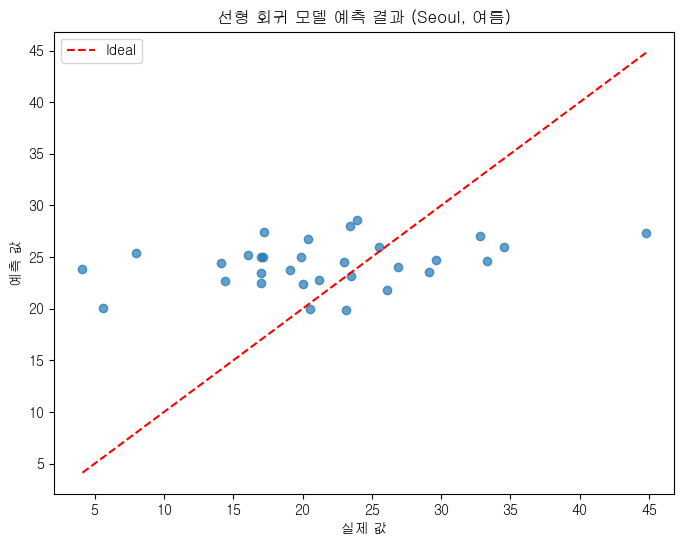

In [45]:
# Cell 7: 선형 회귀 모델을 이용한 학습 점수 및 예측 (예: 겨울 시즌, Seoul)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# 전제: 이전 셀에서 전처리된 merged_data_pm25 데이터프레임과 'Seoul', 'PM2.5 (µg/m³)', 'Wind_X', 'Wind_Y', 'PM2.5_Cluster' 컬럼이 정의되어 있음.
# 'Seoul' 컬럼은 주변국 도시 데이터 (예: pm25 농도)를 의미함.

# 예시로 봄(Season='여름') 시즌 데이터를 사용
season = '여름'
data_season = merged_data_pm25[merged_data_pm25['Season'] == season].dropna()

# 예측 대상 도시가 존재하는지 확인 (예: 'Seoul')
if 'Seoul' not in data_season.columns:
    raise ValueError(f"{season} 시즌에 'Seoul' 데이터가 존재하지 않습니다.")

# 사용할 피처 설정: 기본 특성으로 PM2.5, Wind_X, Wind_Y를 사용하고, 만약 군집화 결과인 'PM2.5_Cluster'가 있다면 추가
features = ['PM2.5 (µg/m³)', 'Wind_X', 'Wind_Y']
if 'PM2.5_Cluster' in data_season.columns:
    features.append('PM2.5_Cluster')

X_lr = data_season[features]
y_lr = data_season['Seoul']  # 서울 데이터 예측

# train-test 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
lr = LinearRegression()
lr.fit(X_train, y_train)

# 예측 수행
y_pred = lr.predict(X_test)

# 평가 지표 계산
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print("선형 회귀 모델 평가 (Seoul, 여름):")
print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R²: {r2_lr:.2f}")

# 예측 결과 시각화 (실제 값 vs. 예측 값)
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.title(f"선형 회귀 모델 예측 결과 (Seoul, {season})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.legend()
plt.show()